In [3]:
# Naive Bays with tfidf only
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import joblib

In [7]:
# Load preprocessed TF-IDF features
df_tfidf = pd.read_pickle('tfidf.pkl')
print(df_tfidf)

     tfidf_0  tfidf_1  tfidf_2  tfidf_3  tfidf_4   tfidf_5  tfidf_6  tfidf_7  \
0        0.0      0.0      0.0      0.0  0.00000  0.000000      0.0      0.0   
1        0.0      0.0      0.0      0.0  0.00000  0.089294      0.0      0.0   
2        0.0      0.0      0.0      0.0  0.00000  0.000000      0.0      0.0   
3        0.0      0.0      0.0      0.0  0.00000  0.000000      0.0      0.0   
4        0.0      0.0      0.0      0.0  0.00000  0.000000      0.0      0.0   
..       ...      ...      ...      ...      ...       ...      ...      ...   
995      0.0      0.0      0.0      0.0  0.00000  0.000000      0.0      0.0   
996      0.0      0.0      0.0      0.0  0.15174  0.000000      0.0      0.0   
997      0.0      0.0      0.0      0.0  0.00000  0.000000      0.0      0.0   
998      0.0      0.0      0.0      0.0  0.00000  0.000000      0.0      0.0   
999      0.0      0.0      0.0      0.0  0.00000  0.000000      0.0      0.0   

     tfidf_8  tfidf_9  ...  tfidf_7034 

In [9]:
# Separate features and labels
X = df_tfidf.drop(['label', 'label_num'], axis=1).values
y = df_tfidf['label_num'].values
classes = np.unique(y)
y_binarized = label_binarize(y, classes=classes)

In [11]:
# Set up 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [13]:
# Store metrics
accuracies = []
roc_aucs = []

In [15]:
# Start cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_test_binarized = y_binarized[test_index]

    # Train model
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Predict probabilities for ROC-AUC
    y_proba = model.predict_proba(X_test)

    # Evaluate
    acc = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')

    # Store results
    accuracies.append(acc)
    roc_aucs.append(roc_auc)

    print(f"Fold {fold}: Accuracy = {acc:.4f}, ROC-AUC = {roc_auc:.4f}")

Fold 1: Accuracy = 0.9200, ROC-AUC = 0.9856
Fold 2: Accuracy = 0.9400, ROC-AUC = 0.9945
Fold 3: Accuracy = 0.9600, ROC-AUC = 0.9986
Fold 4: Accuracy = 0.9300, ROC-AUC = 0.9912
Fold 5: Accuracy = 0.9500, ROC-AUC = 0.9971
Fold 6: Accuracy = 0.9300, ROC-AUC = 0.9959
Fold 7: Accuracy = 0.9100, ROC-AUC = 0.9969
Fold 8: Accuracy = 0.9100, ROC-AUC = 0.9879
Fold 9: Accuracy = 0.9700, ROC-AUC = 0.9974
Fold 10: Accuracy = 0.8800, ROC-AUC = 0.9881


In [17]:
# Final results
print("\n=== Cross-Validation Results ===")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average ROC-AUC: {np.mean(roc_aucs):.4f}")


=== Cross-Validation Results ===
Average Accuracy: 0.9300
Average ROC-AUC: 0.9933


In [24]:
# Accuracy too high.
# 2. Is There Data Leakage?
# What is Data Leakage?
# Data leakage happens when information from outside the training data — especially from the test set — sneaks into the model during training.

# Do NOT apply feature extraction (like TF-IDF or BoW) on the entire dataset before cross-validation.
# Instead, fit your vectorizers within each fold.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

sampled_labeled_partitions = pd.read_csv('cleaned_labeled_partitions.csv')

X = sampled_labeled_partitions['text'].tolist()
y = sampled_labeled_partitions['label']

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train = [X[i] for i in train_idx]
    X_test = [X[i] for i in test_idx]
    y_train = [y[i] for i in train_idx]
    y_test = [y[i] for i in test_idx]
    y_test_bin = y_bin[test_idx]

    # Fit vectorizer ONLY on training data
    tfidf_vectorizer = TfidfVectorizer()
    X_train_vec = tfidf_vectorizer.fit_transform(X_train)
    X_test_vec = tfidf_vectorizer.transform(X_test)

    model = MultinomialNB()
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    y_pred_proba = model.predict_proba(X_test_vec)

    print(f"Fold {fold} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Fold {fold} ROC-AUC: {roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr'):.4f}")

    # Final results
print("\n=== Cross-Validation Results ===")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average ROC-AUC: {np.mean(roc_aucs):.4f}")
# Now there’s no leakage — vectorizer is fit only on the training split in each fold

Fold 1 Accuracy: 0.9200
Fold 1 ROC-AUC: 0.9849
Fold 2 Accuracy: 0.9400
Fold 2 ROC-AUC: 0.9950
Fold 3 Accuracy: 0.9600
Fold 3 ROC-AUC: 0.9984
Fold 4 Accuracy: 0.9300
Fold 4 ROC-AUC: 0.9896
Fold 5 Accuracy: 0.9500
Fold 5 ROC-AUC: 0.9972
Fold 6 Accuracy: 0.9300
Fold 6 ROC-AUC: 0.9961
Fold 7 Accuracy: 0.9100
Fold 7 ROC-AUC: 0.9975
Fold 8 Accuracy: 0.9100
Fold 8 ROC-AUC: 0.9886
Fold 9 Accuracy: 0.9700
Fold 9 ROC-AUC: 0.9977
Fold 10 Accuracy: 0.8800
Fold 10 ROC-AUC: 0.9874

=== Cross-Validation Results ===
Average Accuracy: 0.9300
Average ROC-AUC: 0.9933


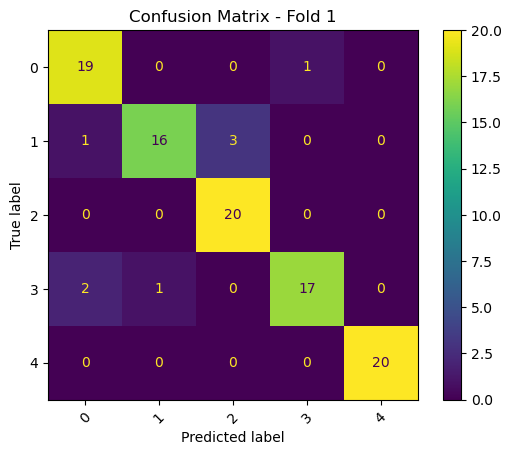

Fold 1: Accuracy = 0.9200, ROC-AUC = 0.9856


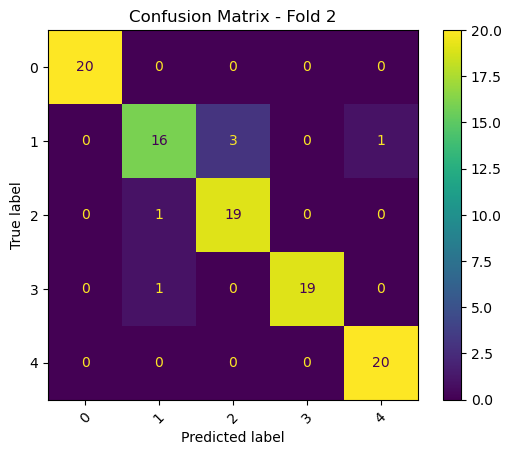

Fold 2: Accuracy = 0.9400, ROC-AUC = 0.9945


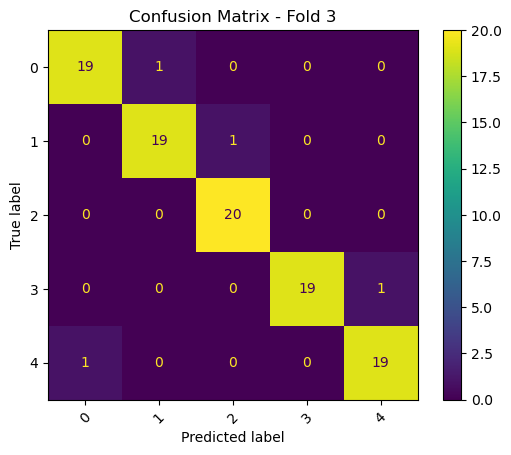

Fold 3: Accuracy = 0.9600, ROC-AUC = 0.9986


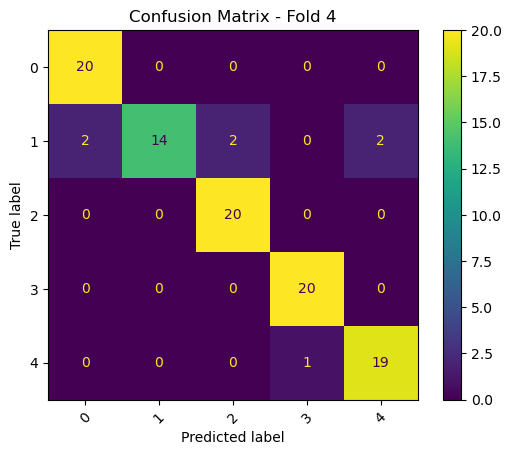

Fold 4: Accuracy = 0.9300, ROC-AUC = 0.9912


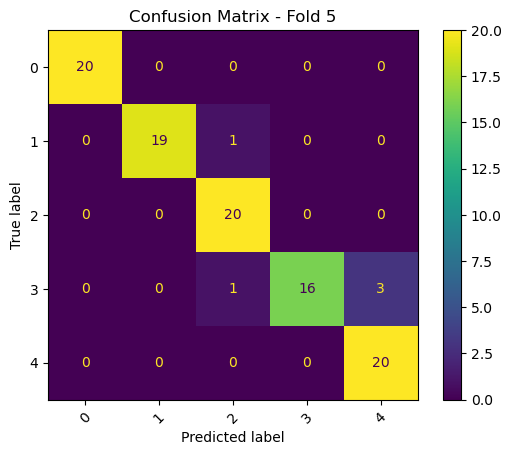

Fold 5: Accuracy = 0.9500, ROC-AUC = 0.9971


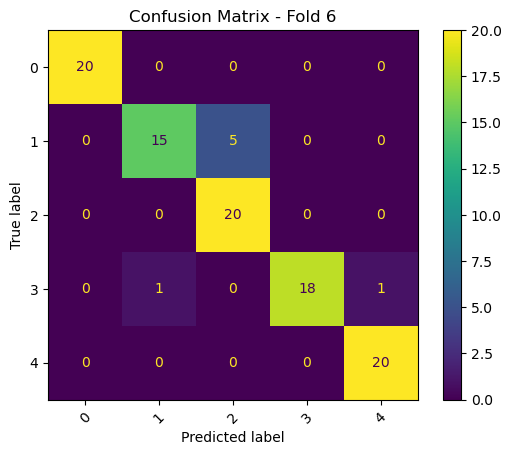

Fold 6: Accuracy = 0.9300, ROC-AUC = 0.9959


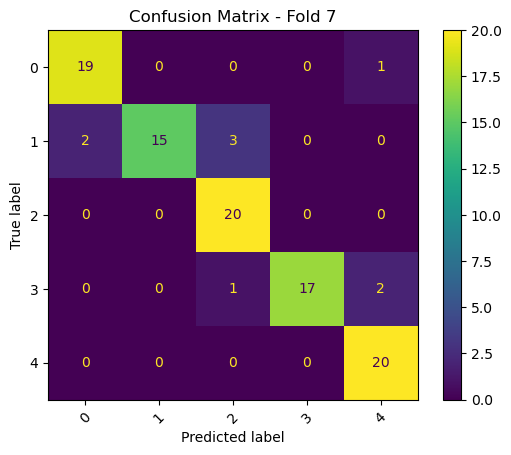

Fold 7: Accuracy = 0.9100, ROC-AUC = 0.9969


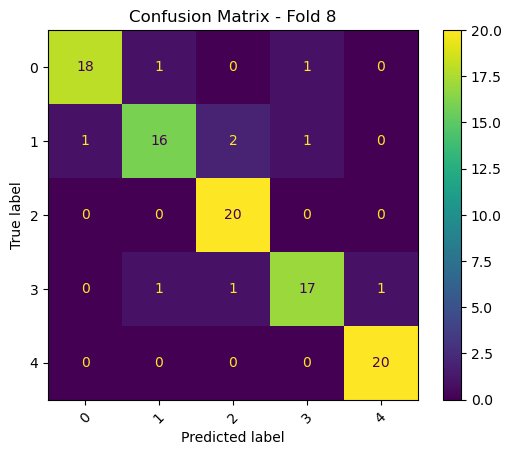

Fold 8: Accuracy = 0.9100, ROC-AUC = 0.9879


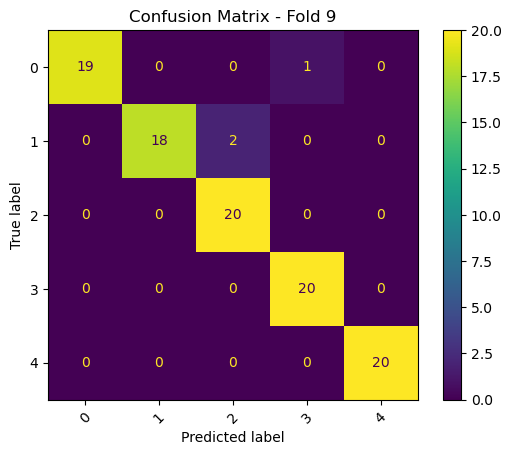

Fold 9: Accuracy = 0.9700, ROC-AUC = 0.9974


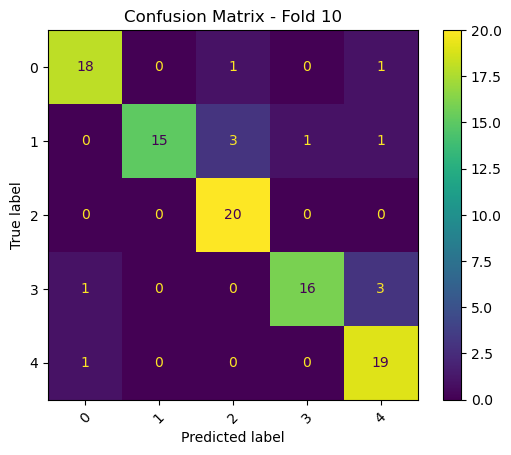

Fold 10: Accuracy = 0.8800, ROC-AUC = 0.9881

=== Cross-Validation Results ===
Average Accuracy: 0.9300
Average ROC-AUC: 0.9933


In [50]:
# Accuracy too high
# Add Confusion Matrix

import pandas as pd 
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import joblib

# Load preprocessed TF-IDF features
df_tfidf = pd.read_pickle('tfidf.pkl')

# Separate features and labels
X = df_tfidf.drop(['label', 'label_num'], axis=1).values
y = df_tfidf['label_num'].values
classes = np.unique(y)
y_binarized = label_binarize(y, classes=classes)

# Set up 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store metrics
accuracies = []
roc_aucs = []

# Start cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_test_binarized = y_binarized[test_index]

    # Train model
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Predict probabilities for ROC-AUC
    y_proba = model.predict_proba(X_test)

    # Evaluate
    y_pred = model.predict(X_test)  # ADD THIS
    acc = accuracy_score(y_test, y_pred)

## insert the confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(xticks_rotation=45)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.show()
    
## End of confusion matrix
    
    roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')

    # Store results
    accuracies.append(acc)
    roc_aucs.append(roc_auc)

    print(f"Fold {fold}: Accuracy = {acc:.4f}, ROC-AUC = {roc_auc:.4f}")

# Final results
print("\n=== Cross-Validation Results ===")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average ROC-AUC: {np.mean(roc_aucs):.4f}")

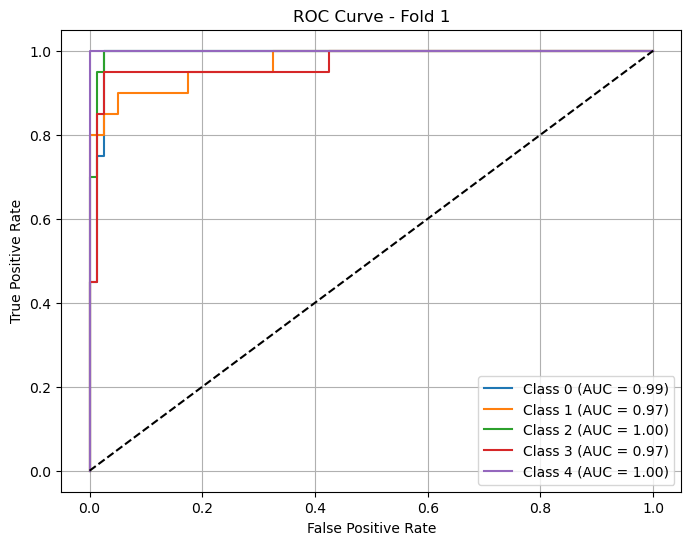

Fold 1: Accuracy = 0.9200, ROC-AUC = 0.9856


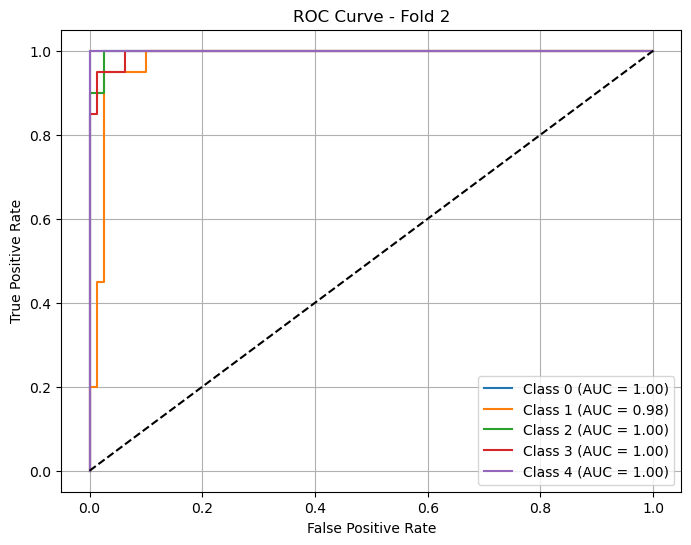

Fold 2: Accuracy = 0.9400, ROC-AUC = 0.9945


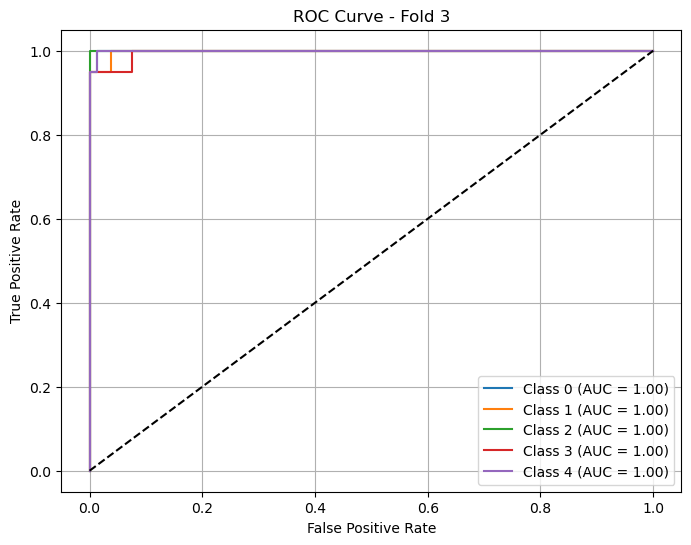

Fold 3: Accuracy = 0.9600, ROC-AUC = 0.9986


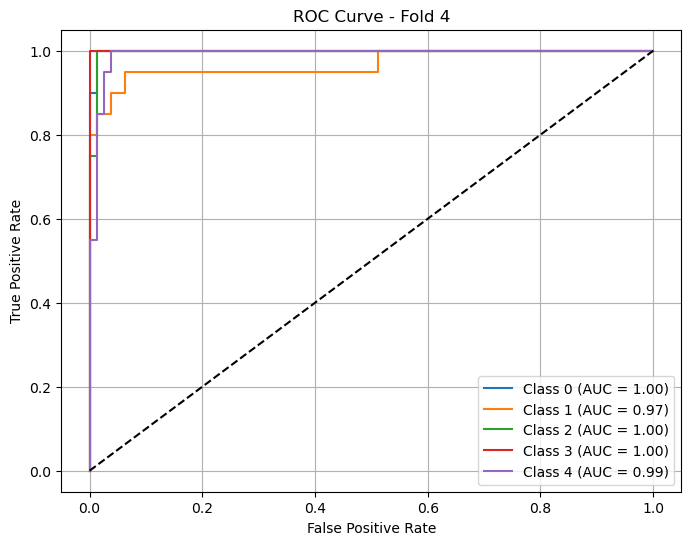

Fold 4: Accuracy = 0.9300, ROC-AUC = 0.9912


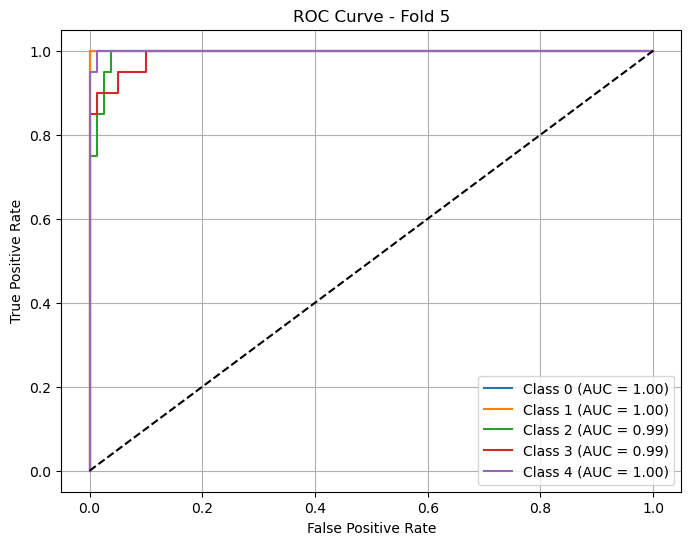

Fold 5: Accuracy = 0.9500, ROC-AUC = 0.9971


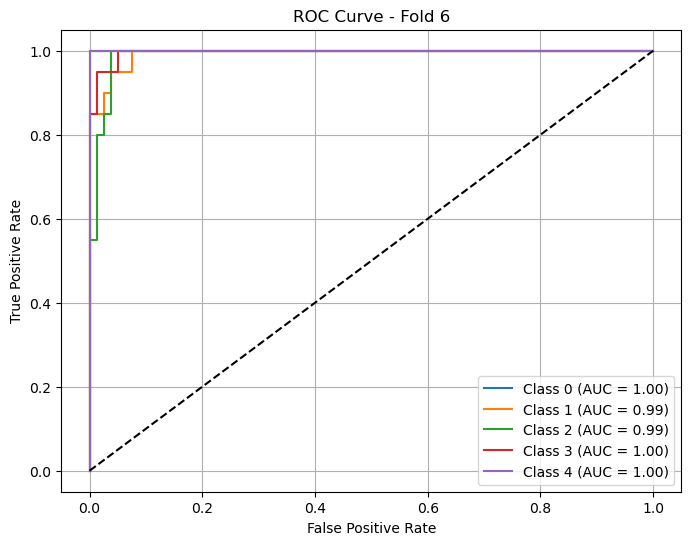

Fold 6: Accuracy = 0.9300, ROC-AUC = 0.9959


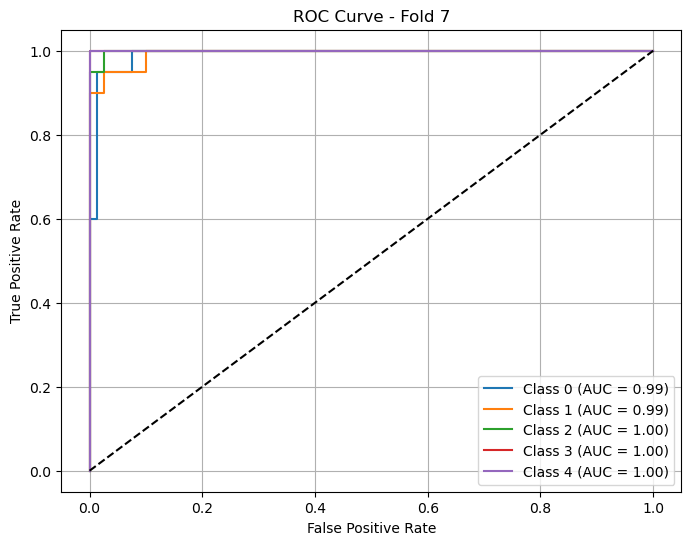

Fold 7: Accuracy = 0.9100, ROC-AUC = 0.9969


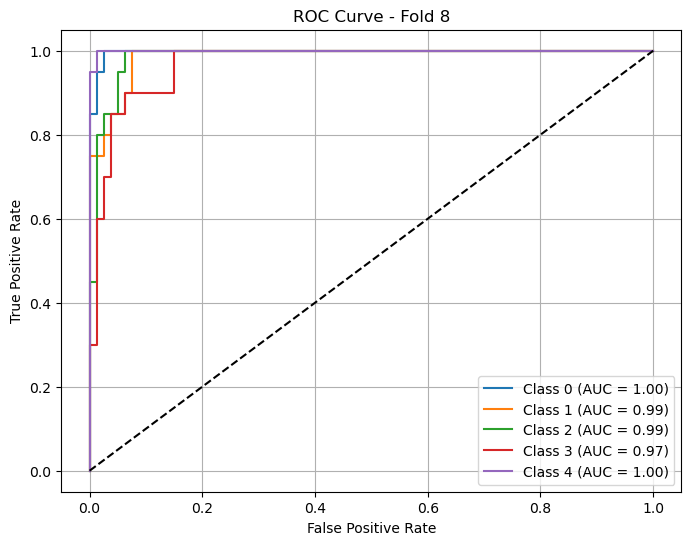

Fold 8: Accuracy = 0.9100, ROC-AUC = 0.9879


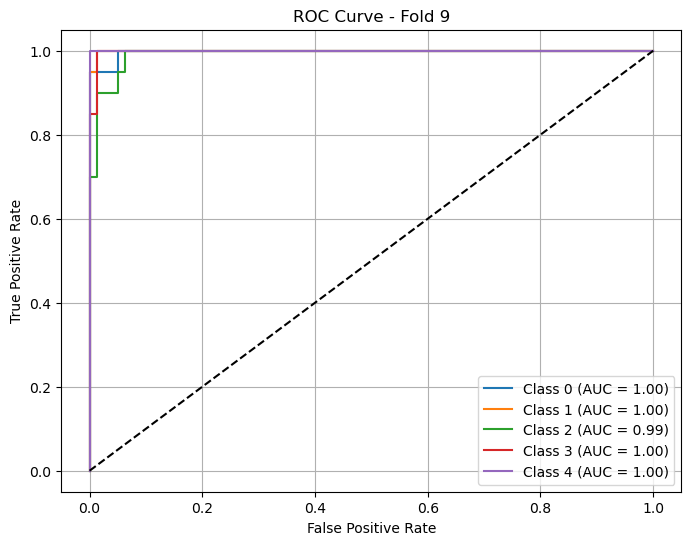

Fold 9: Accuracy = 0.9700, ROC-AUC = 0.9974


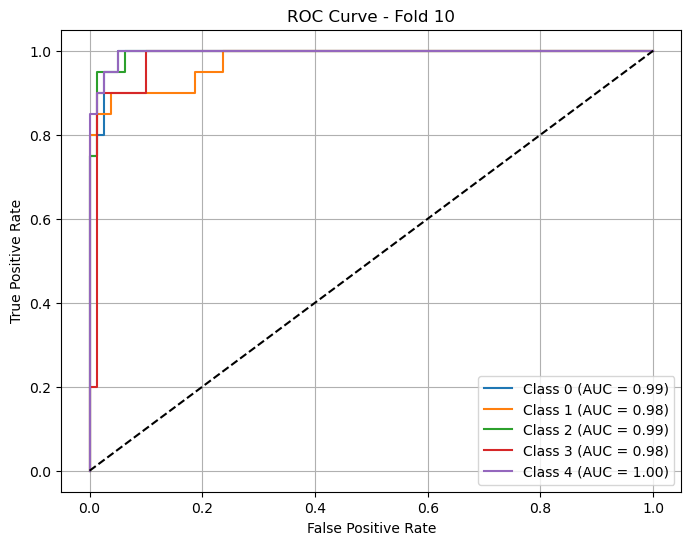

Fold 10: Accuracy = 0.8800, ROC-AUC = 0.9881

=== Cross-Validation Results ===
Average Accuracy: 0.9300
Average ROC-AUC: 0.9933


In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import joblib

# Load preprocessed TF-IDF features
df_tfidf = pd.read_pickle('tfidf.pkl')

# Separate features and labels
X = df_tfidf.drop(['label', 'label_num'], axis=1).values
y = df_tfidf['label_num'].values
classes = np.unique(y)
y_binarized = label_binarize(y, classes=classes)

# Set up 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store metrics
accuracies = []
roc_aucs = []

# Start cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_test_binarized = y_binarized[test_index]

    # Train model
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Predict probabilities for ROC-AUC
    y_proba = model.predict_proba(X_test)


    
# Plot ROC Curves (One-vs-Rest) 
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

# One-vs-rest ROC
    from sklearn.preprocessing import label_binarize
    n_classes = y_proba.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        if y_test_binarized[:, i].sum() == 0:
            continue  # Skip class if not present in test fold

        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
    plt.figure(figsize=(8, 6))
    for i in roc_auc:
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - Fold {fold}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    
    # Evaluate
    acc = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')

    # Store results
    accuracies.append(acc)
    roc_aucs.append(roc_auc)

    print(f"Fold {fold}: Accuracy = {acc:.4f}, ROC-AUC = {roc_auc:.4f}")

# Final results
print("\n=== Cross-Validation Results ===")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average ROC-AUC: {np.mean(roc_aucs):.4f}")

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load raw data instead of vectorized
df = pd.read_csv("cleaned_labeled_partitions.csv")  # This should have 'text' and 'label_num'

X_raw = df['text']
y = df['label']

# Split into train and test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, stratify=y, random_state=42)

# TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

# Train model
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score
print("Final Holdout Accuracy:", accuracy_score(y_test, y_pred))


Final Holdout Accuracy: 0.915


In [55]:
#Naive Bayes 10-fold CV training and evaluation code for the following feature sets:
#-Bag of Words (BoW)
#-N-grams (bigrams)
#-LDA (Topic Modeling)
#-Word2Vec (removed from code because  Naive Bayes does not work well with continuous embeddings like Word2Vec;

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_naive_bayes(X, y, feature_type="Feature"):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    classes = np.unique(y)
    y_binarized = label_binarize(y, classes=classes)

    accuracies, roc_aucs = [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        y_test_bin = y_binarized[test_idx]

        model = MultinomialNB()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        acc = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')

        accuracies.append(acc)
        roc_aucs.append(roc_auc)

        print(f"[{feature_type}] Fold {fold}: Accuracy = {acc:.4f}, ROC-AUC = {roc_auc:.4f}")

    print(f"\n[{feature_type}] Average Accuracy: {np.mean(accuracies):.4f}")
    print(f"[{feature_type}] Average ROC-AUC: {np.mean(roc_aucs):.4f}\n")


# Load feature dataframes and evaluate

# Bag of Words
df_bow = pd.read_pickle('bow.pkl')
X_bow = df_bow.drop(['label', 'label_num'], axis=1).values
y_bow = df_bow['label_num'].values
evaluate_naive_bayes(X_bow, y_bow, feature_type="Bag of Words")

# N-grams (bigrams)
df_ngram = pd.read_pickle('ngram.pkl')
X_ngram = df_ngram.drop(['label', 'label_num'], axis=1).values
y_ngram = df_ngram['label_num'].values
evaluate_naive_bayes(X_ngram, y_ngram, feature_type="N-grams")

# LDA
df_lda = pd.read_pickle('lda.pkl')
X_lda = df_lda.drop(['label', 'label_num'], axis=1).values
y_lda = df_lda['label_num'].values
evaluate_naive_bayes(X_lda, y_lda, feature_type="LDA")

[Bag of Words] Fold 1: Accuracy = 0.9400, ROC-AUC = 0.9861
[Bag of Words] Fold 2: Accuracy = 0.9500, ROC-AUC = 0.9964
[Bag of Words] Fold 3: Accuracy = 0.9600, ROC-AUC = 0.9986
[Bag of Words] Fold 4: Accuracy = 0.9400, ROC-AUC = 0.9933
[Bag of Words] Fold 5: Accuracy = 0.9500, ROC-AUC = 0.9983
[Bag of Words] Fold 6: Accuracy = 0.9300, ROC-AUC = 0.9971
[Bag of Words] Fold 7: Accuracy = 0.9200, ROC-AUC = 0.9968
[Bag of Words] Fold 8: Accuracy = 0.9100, ROC-AUC = 0.9890
[Bag of Words] Fold 9: Accuracy = 0.9800, ROC-AUC = 0.9989
[Bag of Words] Fold 10: Accuracy = 0.8800, ROC-AUC = 0.9909

[Bag of Words] Average Accuracy: 0.9360
[Bag of Words] Average ROC-AUC: 0.9945

[N-grams] Fold 1: Accuracy = 0.9200, ROC-AUC = 0.9951
[N-grams] Fold 2: Accuracy = 0.9300, ROC-AUC = 0.9886
[N-grams] Fold 3: Accuracy = 0.9500, ROC-AUC = 0.9980
[N-grams] Fold 4: Accuracy = 0.9300, ROC-AUC = 0.9964
[N-grams] Fold 5: Accuracy = 0.9200, ROC-AUC = 0.9956
[N-grams] Fold 6: Accuracy = 0.9400, ROC-AUC = 0.9889
[N-g

In [59]:
# Define a function to run 10-fold CV on any feature set with Naive Bayes
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_naive_bayes(X, y, feature_type=""):
    classes = np.unique(y)
    y_binarized = label_binarize(y, classes=classes)

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    accuracies = []
    roc_aucs = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        y_test_binarized = y_binarized[test_idx]

        model = MultinomialNB()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        acc = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')

        accuracies.append(acc)
        roc_aucs.append(roc_auc)

        print(f"{feature_type} - Fold {fold}: Accuracy={acc:.4f}, ROC-AUC={roc_auc:.4f}")

    print(f"\n{feature_type} - Average Accuracy: {np.mean(accuracies):.4f}")
    print(f"{feature_type} - Average ROC-AUC: {np.mean(roc_aucs):.4f}\n")


In [61]:
# Load individual feature sets
df_bow = pd.read_pickle('bow.pkl')
df_ngram = pd.read_pickle('ngram.pkl')
df_lda = pd.read_pickle('lda.pkl')

y = df_bow['label_num'].values  # Labels should be same across


In [63]:
# Combine feature sets horizontally
import numpy as np

X_bow = df_bow.drop(['label', 'label_num'], axis=1).values
X_ngram = df_ngram.drop(['label', 'label_num'], axis=1).values
X_lda = df_lda.drop(['label', 'label_num'], axis=1).values

# Combine BoW + N-grams
X_bow_ngram = np.hstack([X_bow, X_ngram])

# Combine BoW + LDA
X_bow_lda = np.hstack([X_bow, X_lda])

# Combine N-grams + LDA
X_ngram_lda = np.hstack([X_ngram, X_lda])

# Combine all three
X_all = np.hstack([X_bow, X_ngram, X_lda])

In [67]:
# Evaluate Naive Bayes on combined feature sets
evaluate_naive_bayes(X_bow_ngram, y, "BoW + N-grams")
evaluate_naive_bayes(X_bow_lda, y, "BoW + LDA")
evaluate_naive_bayes(X_ngram_lda, y, "N-grams + LDA")
evaluate_naive_bayes(X_all, y, "BoW + N-grams + LDA")


BoW + N-grams - Fold 1: Accuracy=0.9600, ROC-AUC=0.9926
BoW + N-grams - Fold 2: Accuracy=0.9500, ROC-AUC=0.9939
BoW + N-grams - Fold 3: Accuracy=0.9700, ROC-AUC=0.9994
BoW + N-grams - Fold 4: Accuracy=0.9600, ROC-AUC=0.9952
BoW + N-grams - Fold 5: Accuracy=0.9600, ROC-AUC=0.9980
BoW + N-grams - Fold 6: Accuracy=0.9400, ROC-AUC=0.9931
BoW + N-grams - Fold 7: Accuracy=0.9200, ROC-AUC=0.9976
BoW + N-grams - Fold 8: Accuracy=0.9300, ROC-AUC=0.9916
BoW + N-grams - Fold 9: Accuracy=0.9800, ROC-AUC=0.9992
BoW + N-grams - Fold 10: Accuracy=0.9000, ROC-AUC=0.9906

BoW + N-grams - Average Accuracy: 0.9470
BoW + N-grams - Average ROC-AUC: 0.9951

BoW + LDA - Fold 1: Accuracy=0.9400, ROC-AUC=0.9854
BoW + LDA - Fold 2: Accuracy=0.9500, ROC-AUC=0.9964
BoW + LDA - Fold 3: Accuracy=0.9500, ROC-AUC=0.9986
BoW + LDA - Fold 4: Accuracy=0.9400, ROC-AUC=0.9933
BoW + LDA - Fold 5: Accuracy=0.9500, ROC-AUC=0.9986
BoW + LDA - Fold 6: Accuracy=0.9300, ROC-AUC=0.9972
BoW + LDA - Fold 7: Accuracy=0.9300, ROC-AUC

In [74]:
# One big functin for all individual features and features combinations. At the end, select the best feature results.

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_naive_bayes(X, y, feature_type=""):
    classes = np.unique(y)
    y_binarized = label_binarize(y, classes=classes)
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    accuracies = []
    roc_aucs = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        y_test_binarized = y_binarized[test_idx]

        model = MultinomialNB()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        acc = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')

        accuracies.append(acc)
        roc_aucs.append(roc_auc)

    print(f"{feature_type}: Average Accuracy = {np.mean(accuracies):.4f}, Average ROC-AUC = {np.mean(roc_aucs):.4f}")
    return np.mean(accuracies), np.mean(roc_aucs)


# Assuming these DataFrames already loaded:
# df_bow, df_tfidf, df_ngram, df_lda

y = df_tfidf['label_num'].values  # labels should be same for all

# Extract features arrays
X_bow = df_bow.drop(['label', 'label_num'], axis=1).values
X_tfidf = df_tfidf.drop(['label', 'label_num'], axis=1).values
X_ngram = df_ngram.drop(['label', 'label_num'], axis=1).values
X_lda = df_lda.drop(['label', 'label_num'], axis=1).values

# Create combinations (you can customize as needed)
X_bow_tfidf = np.hstack([X_bow, X_tfidf])
X_bow_ngram = np.hstack([X_bow, X_ngram])
X_bow_lda = np.hstack([X_bow, X_lda])
X_tfidf_ngram = np.hstack([X_tfidf, X_ngram])
X_tfidf_lda = np.hstack([X_tfidf, X_lda])
X_ngram_lda = np.hstack([X_ngram, X_lda])
X_all = np.hstack([X_bow, X_tfidf, X_ngram, X_lda])

results = {}

# Individual feature sets
results['BoW'] = evaluate_naive_bayes(X_bow, y, "BoW")
results['TF-IDF'] = evaluate_naive_bayes(X_tfidf, y, "TF-IDF")
results['N-grams'] = evaluate_naive_bayes(X_ngram, y, "N-grams")
results['LDA'] = evaluate_naive_bayes(X_lda, y, "LDA")

# Pairwise combinations
results['BoW + TF-IDF'] = evaluate_naive_bayes(X_bow_tfidf, y, "BoW + TF-IDF")
results['BoW + N-grams'] = evaluate_naive_bayes(X_bow_ngram, y, "BoW + N-grams")
results['BoW + LDA'] = evaluate_naive_bayes(X_bow_lda, y, "BoW + LDA")
results['TF-IDF + N-grams'] = evaluate_naive_bayes(X_tfidf_ngram, y, "TF-IDF + N-grams")
results['TF-IDF + LDA'] = evaluate_naive_bayes(X_tfidf_lda, y, "TF-IDF + LDA")
results['N-grams + LDA'] = evaluate_naive_bayes(X_ngram_lda, y, "N-grams + LDA")

# All combined
results['All Combined'] = evaluate_naive_bayes(X_all, y, "BoW + TF-IDF + N-grams + LDA")

# Summary
# ... [previous code remains unchanged] ...

# Summary
print("\nSummary of Results:")
print(f"{'Feature Set':<25} {'Accuracy':<10} {'ROC-AUC':<10}")
for key, (acc, roc) in results.items():
    print(f"{key:<25} {acc:<10.4f} {roc:<10.4f}")

# Select the best feature set by accuracy
best_feature_set = max(results.items(), key=lambda x: x[1][0])  # max by accuracy (index 0)
best_name, (best_acc, best_roc) = best_feature_set

print("\n=== Best Feature Set ===")
print(f"Feature Set: {best_name}")
print(f"Accuracy: {best_acc:.4f}")
print(f"ROC-AUC: {best_roc:.4f}")

BoW: Average Accuracy = 0.9360, Average ROC-AUC = 0.9945
TF-IDF: Average Accuracy = 0.9300, Average ROC-AUC = 0.9933
N-grams: Average Accuracy = 0.9120, Average ROC-AUC = 0.9906
LDA: Average Accuracy = 0.5300, Average ROC-AUC = 0.8223
BoW + TF-IDF: Average Accuracy = 0.9360, Average ROC-AUC = 0.9945
BoW + N-grams: Average Accuracy = 0.9470, Average ROC-AUC = 0.9951
BoW + LDA: Average Accuracy = 0.9360, Average ROC-AUC = 0.9945
TF-IDF + N-grams: Average Accuracy = 0.9170, Average ROC-AUC = 0.9920
TF-IDF + LDA: Average Accuracy = 0.8660, Average ROC-AUC = 0.9824
N-grams + LDA: Average Accuracy = 0.9140, Average ROC-AUC = 0.9912
BoW + TF-IDF + N-grams + LDA: Average Accuracy = 0.9470, Average ROC-AUC = 0.9951

Summary of Results:
Feature Set               Accuracy   ROC-AUC   
BoW                       0.9360     0.9945    
TF-IDF                    0.9300     0.9933    
N-grams                   0.9120     0.9906    
LDA                       0.5300     0.8223    
BoW + TF-IDF           

In [78]:
# Save results to a file for later comparison
import pickle
import os

nb_file = "naive_bayes_results.pkl"
with open(nb_file, "wb") as f:
    pickle.dump(results, f)

# Confirm file was saved
if os.path.exists(nb_file):
    print(f"Naive Bayes results successfully saved to '{nb_file}'.")
else:
    print(f"Failed to save Naive Bayes results.")


Naive Bayes results successfully saved to 'naive_bayes_results.pkl'.
